# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

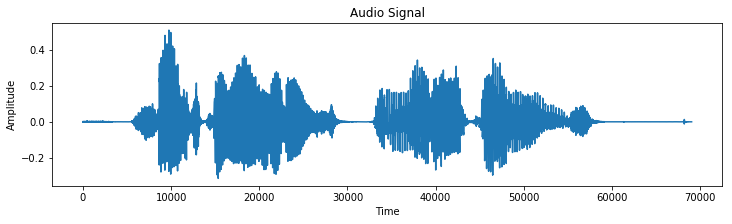

**Shape of Audio Signal** : (69017,)

**Transcript** : shasta rambles and modoc memories

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

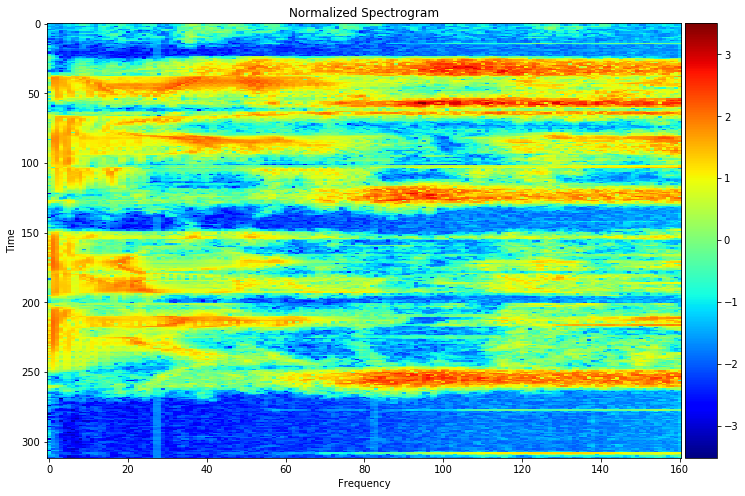

**Shape of Spectrogram** : (312, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

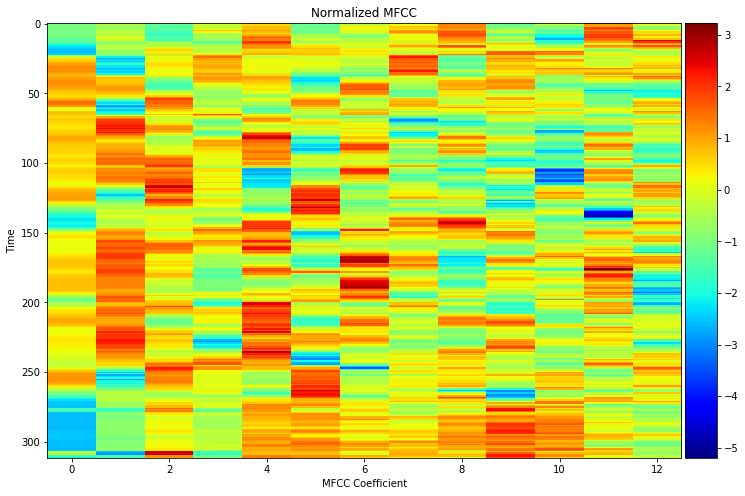

**Shape of MFCC** : (312, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
from wer import wer
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
import numpy as np


def calculate_wer2(input_to_softmax, model_path, words=False):
    
    
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    wers = []
    for index in range(len(data_gen.valid_texts)):
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))

        input_to_softmax.load_weights(model_path)
        prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
        output_length = [input_to_softmax.output_length(data_point.shape[0])] 
        pred_ints = (K.eval(K.ctc_decode(
                    prediction, output_length)[0][0])+1).flatten().tolist()

        pred = ''.join(int_sequence_to_text(pred_ints))

        if words:
            w = wer(transcr.split(), pred.split())
        else:
            w = wer(list(transcr), list(pred))
        wers.append(w)
        if index % 100 == 0:
            print(index, len(data_gen.valid_texts), wers[-1])
        
    print("FINAL WER:", sum(wers) / len(wers), "words:", words)

<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [2]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [ ]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
 62/106 [================>.............] - ETA: 35s - loss: 869.0023

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [2]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
106/106 [==============================] - 100s 943ms/step - loss: nan - val_loss: nan
Epoch 2/20
106/106 [==============================] - 97s 912ms/step - loss: nan - val_loss: nan
Epoch 3/20
106/106 [==============================] - 96s 902ms/step - loss: nan - val_loss: nan
Epoch 4/20
106/106 [==============================] - 96s 909ms/step - loss: nan - val_loss: nan
Epoch 5/20
106/106 [==============================] - 96s 908ms/step - loss: nan - val_loss: nan
Epoch 6/20
 60/106 [===============>..............] - ETA: 32s - loss: nan

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [3]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/layers/recurrent.py:1056: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0   

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [4]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
106/106 [==============================] - 40s 377ms/step - loss: 244.0662 - val_loss: 240.8722
Epoch 2/20
106/106 [==============================] - 31s 295ms/step - loss: 203.7180 - val_loss: 187.2374
Epoch 3/20
106/106 [==============================] - 30s 282ms/step - loss: 167.9299 - val_loss: 165.9509
Epoch 4/20
106/106 [==============================] - 30s 281ms/step - loss: 148.3119 - val_loss: 147.1337
Epoch 5/20
106/106 [==============================] - 31s 288ms/step - loss: 138.0427 - val_loss: 140.1443
Epoch 6/20
106/106 [==============================] - 29s 277ms/step - loss: 130.2383 - val_loss: 135.0378
Epoch 7/20
106/106 [==============================] - 29s 276ms/step - loss: 124.2759 - val_loss: 133.5255
Epoch 8/20
106/106 [==============================] - 29s 271ms/step - loss: 118.9710 - val_loss: 132.4187
Epoch 9/20
106/106

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [8]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
gru_7 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 200)         800       
_________________________________________________________________
gru_8 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0   

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [9]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
106/106 [==============================] - 195s 2s/step - loss: 309.8848 - val_loss: 246.2669
Epoch 2/20
106/106 [==============================] - 193s 2s/step - loss: 237.3204 - val_loss: 207.8681
Epoch 3/20
106/106 [==============================] - 191s 2s/step - loss: 212.9297 - val_loss: 191.4147
Epoch 4/20
106/106 [==============================] - 194s 2s/step - loss: 187.2999 - val_loss: 176.1941
Epoch 5/20
106/106 [==============================] - 198s 2s/step - loss: 168.4858 - val_loss: 161.7191
Epoch 6/20
106/106 [==============================] - 197s 2s/step - loss: 157.8072 - val_loss: 154.8817
Epoch 7/20
106/106 [==============================] - 198s 2s/step - loss: 149.9549 - val_loss: 150.0909
Epoch 8/20
106/106 [==============================] - 188s 2s/step - loss: 143.0062 - val_loss: 145.9378
Epoch 9/20
106/106 [==============

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [2]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         579200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 590,829
Trainable params: 590,829
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
106/106 [==============================] - 245s 2s/step - loss: 295.0137 - val_loss: 209.1240
Epoch 2/20
106/106 [==============================] - 249s 2s/step - loss: 208.2431 - val_loss: 191.6197
Epoch 3/20
106/106 [==============================] - 250s 2s/step - loss: 192.3528 - val_loss: 181.7321
Epoch 4/20
106/106 [==============================] - 254s 2s/step - loss: 181.0450 - val_loss: 171.9478
Epoch 5/20
106/106 [==============================] - 248s 2s/step - loss: 170.3944 - val_loss: 165.3937
Epoch 6/20
106/106 [==============================] - 247s 2s/step - loss: 160.5945 - val_loss: 159.1532
Epoch 7/20
106/106 [==============================] - 247s 2s/step - loss: 152.2178 - val_loss: 155.2177
Epoch 8/20
106/106 [==============================] - 249s 2s/step - loss: 145.2970 - val_loss: 153.2083
Epoch 9/20
106/106 [==============

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.
model_deep_bidir_sepconv = model_deep_bidir_sepconv(input_dim=161, # change to 13 if MFCC
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid')

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (SeparableConv1D)     (None, None, 200)         34171     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          44736     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          18624     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_____________________________________________________

In [3]:
train_model(input_to_softmax=model_deep_bidir_sepconv, 
            pickle_path='model_deep_bidir_sepconv.pickle', 
            save_model_path='model_deep_bidir_sepconv.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
106/106 [==============================] - 198s 2s/step - loss: 234.8546 - val_loss: 201.3954
Epoch 2/20
106/106 [==============================] - 179s 2s/step - loss: 172.9820 - val_loss: 167.7541
Epoch 3/20
106/106 [==============================] - 174s 2s/step - loss: 151.4238 - val_loss: 150.1749
Epoch 4/20
106/106 [==============================] - 179s 2s/step - loss: 139.6843 - val_loss: 146.3907
Epoch 5/20
106/106 [==============================] - 176s 2s/step - loss: 131.7916 - val_loss: 134.8577
Epoch 6/20
106/106 [==============================] - 186s 2s/step - loss: 126.3000 - val_loss: 131.3243
Epoch 7/20
106/106 [==============================] - 188s 2s/step - loss: 121.5070 - val_loss: 134.5742
Epoch 8/20
106/106 [==============================] - 180s 2s/step - loss: 117.5508 - val_loss: 128.7587
Epoch 9/20
106/106 [==============

In [2]:
model_deep_bidir_sepconv_alt = model_deep_bidir_sepconv(input_dim=161, # change to 13 if MFCC
                        filters=200,
                        kernel_size=17, 
                        conv_stride=4,
                        conv_border_mode='valid')
train_model(input_to_softmax=model_deep_bidir_sepconv_alt, 
            pickle_path='model_deep_bidir_sepconv_alt.pickle', 
            save_model_path='model_deep_bidir_sepconv_alt.h5', 
            spectrogram=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (SeparableConv1D)     (None, None, 200)         35137     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          44736     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          18624     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_____________________________________________________

In [3]:
model_deep_bidir_sepconv_alt2 = model_deep_bidir_sepconv(input_dim=161, # change to 13 if MFCC
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recurrent_sizes=[32, 32, 32, 32])
train_model(input_to_softmax=model_deep_bidir_sepconv_alt2, 
            pickle_path='model_deep_bidir_sepconv_alt2.pickle', 
            save_model_path='model_deep_bidir_sepconv_alt2.h5', 
            spectrogram=True)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (SeparableConv1D)     (None, None, 200)         34171     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          44736     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 64)          18624     
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          1862

In [2]:
model_deep_bidir_deep_sepconv_ = model_deep_bidir_deep_sepconv(input_dim=161, # change to 13 if MFCC
                        filters=[200, 150],
                        kernel_size=11, 
                        conv_stride=1,
                        conv_border_mode='valid')

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, None, 200)         34171     
_________________________________________________________________
separable_conv1d_2 (Separabl (None, None, 150)         32350     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          35136     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          18624     
_____________________________________________________

In [3]:
train_model(input_to_softmax=model_deep_bidir_deep_sepconv_, 
            pickle_path='model_deep_bidir_deep_sepconv.pickle', 
            save_model_path='model_deep_bidir_deep_sepconv.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
268/268 [==============================] - 918s 3s/step - loss: 278.9246 - val_loss: 208.6208
Epoch 2/20
268/268 [==============================] - 913s 3s/step - loss: 238.0912 - val_loss: 185.3221
Epoch 3/20
268/268 [==============================] - 891s 3s/step - loss: 192.8419 - val_loss: 153.3741
Epoch 4/20
268/268 [==============================] - 864s 3s/step - loss: 167.0574 - val_loss: 136.3798
Epoch 5/20
268/268 [==============================] - 842s 3s/step - loss: 153.6640 - val_loss: 129.7447
Epoch 6/20
268/268 [==============================] - 816s 3s/step - loss: 145.4147 - val_loss: 122.1201
Epoch 7/20
268/268 [==============================] - 827s 3s/step - loss: 139.3820 - val_loss: 113.0425
Epoch 8/20
268/268 [==============================] - 860s 3s/step - loss: 133.8680 - val_loss: 112.6947
Epoch 9/20
268/268 [==============

In [23]:
jasper_model_ = jasper_model(161)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d_142 (Conv1D)             (None, None, 256)    453632      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, None, 256)    1024        conv1d_142[0][0]                 
__________________________________________________________________________________________________
re_lu_97 (ReLU)                 (None, None, 256)    0           batch_normalization_134[0][0]    
___________________________________________________________________________________________

In [ ]:
train_model(input_to_softmax=jasper_model_, 
            pickle_path='jasper_model_.pickle', 
            save_model_path='jasper_model_.h5', 
            spectrogram=True, min_duration=10.0, max_duration=10000., minibatch_size=5)

Epoch 1/20
  18/4635 [..............................] - ETA: 4:38:52 - loss: 970.2763

In [2]:
quartznet_model_ = quartznet_model(161, R=1, B=1)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, None, 256)    46785       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 256)    1024        separable_conv1d_1[0][0]         
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, None, 256)    0           batch_normalization_1[0][0]      
____________________

In [ ]:
train_model(input_to_softmax=quartznet_model_, 
            pickle_path='quartznet_model_.pickle', 
            save_model_path='quartznet_model_.h5', 
            spectrogram=True, min_duration=10.0, max_duration=10000., minibatch_size=5)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
  28/4635 [..............................] - ETA: 40:01 - loss: 836.9599

In [3]:
quartz_12x1 = quartznet_12x1(161)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_15 (Separab (None, None, 256)         46785     
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 256)         1024      
_________________________________________________________________
re_lu_15 (ReLU)              (None, None, 256)         0         
_________________________________________________________________
separable_conv1d_16 (Separab (None, None, 256)         74240     
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 256)         1024      
_________________________________________________________________
re_lu_16 (ReLU)              (None, None, 256)         0   

In [ ]:
train_model(input_to_softmax=quartz_12x1, 
            pickle_path='quartz_12x1.pickle', 
            save_model_path='quartz_12x1.h5', 
            spectrogram=True, min_duration=10.0, max_duration=10000., minibatch_size=5)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
4635/4635 [==============================] - 2762s 596ms/step - loss: 528.2011 - val_loss: 586.8991
Epoch 2/20
4635/4635 [==============================] - 2664s 575ms/step - loss: 509.7217 - val_loss: 546.9270
Epoch 3/20
4635/4635 [==============================] - 2661s 574ms/step - loss: 508.5228 - val_loss: 558.7751
Epoch 4/20
4635/4635 [==============================] - 2659s 574ms/step - loss: 502.7786 - val_loss: 531.2605
Epoch 5/20
4635/4635 [==============================] - 2659s 574ms/step - loss: 488.7789 - val_loss: 525.5025
Epoch 6/20
4635/4635 [==============================] - 2658s 574ms/step - loss: 474.6992 - val_loss: 499.2475
Epoch 7/20
4635/4635 [==============================] - 2660s 574ms/step - loss: 453.7915 - val_loss: 476.5669
Epoch 8/20
4635/4635 [==============================] - 2658s 573ms/step - loss: 425.6215 - val_l

In [2]:
quartz_15x5 = quartznet_15x5(161)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, None, 256)         46785     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, 256)         0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, None, 256)         74240     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 256)         1024      
_____________________________________________________

In [3]:
train_model(input_to_softmax=quartz_15x5, 
            pickle_path='quartz_15x5.pickle', 
            save_model_path='quartz_15x5.h5', 
            spectrogram=True, min_duration=10.0, max_duration=10000., minibatch_size=5)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
2519/4635 [===============>..............] - ETA: 1:41:18 - loss: 604.6432

ResourceExhaustedError: OOM when allocating tensor with shape[5,512,1,1226] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node separable_conv1d_67/separable_conv2d/depthwise}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node training/SGD/gradients/ctc/ExpandDims_grad/Reshape}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [3]:
quartz_1212151 = quartznet_12x1_15_39(161)
train_model(input_to_softmax=quartz_1212151, 
            pickle_path='quartz_1212151.pickle', 
            save_model_path='quartz_1212151.h5', 
            spectrogram=True, min_duration=10.0, max_duration=10000., minibatch_size=5, wer=calculate_wer2, epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, None, 128)         23151     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, 128)         0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, None, 128)         18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_____________________________________________________

700 2007 81.81818181818183
800 2007 122.22222222222223
900 2007 100.0
1000 2007 93.33333333333333
1100 2007 81.81818181818183
1200 2007 60.0
1300 2007 88.88888888888889
1400 2007 90.0
1500 2007 95.83333333333334
1600 2007 90.9090909090909
1700 2007 100.0
1800 2007 80.0
1900 2007 76.92307692307693
2000 2007 85.71428571428571
FINAL WER: 93.75889101378061 words: True
0 2007 51.4018691588785
100 2007 56.16438356164384
200 2007 51.21951219512195
300 2007 50.72463768115942
400 2007 52.77777777777778
500 2007 50.0
600 2007 64.51612903225806
700 2007 46.55172413793103
800 2007 57.758620689655174
900 2007 47.2972972972973
1000 2007 51.5625
1100 2007 44.89795918367347
1200 2007 26.923076923076923
1300 2007 41.37931034482759
1400 2007 55.00000000000001
1500 2007 59.66386554621849
1600 2007 48.214285714285715
1700 2007 61.81818181818181
1800 2007 35.36585365853659
1900 2007 40.0
2000 2007 57.14285714285714
FINAL WER: 50.13554038163212 words: False
Epoch 2/50
4635/4635 [============================

In [4]:
quartz_1212151_10 = quartznet_12x1_15_39(161)
train_model(input_to_softmax=quartz_1212151_10, 
            pickle_path='quartz_1212151_10.pickle', 
            save_model_path='quartz_1212151_10.h5', 
            spectrogram=True, minibatch_size=5, epochs=20)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_18 (Separab (None, None, 128)         23151     
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_17 (ReLU)              (None, None, 128)         0         
_________________________________________________________________
separable_conv1d_19 (Separab (None, None, 128)         18432     
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_18 (ReLU)              (None, None, 128)         0   

In [6]:
#calculate_wer(input_to_softmax=quartznet_12x1_15_39(161), model_path='results/quartz_1212151_10.h5', chars=True)
calculate_wer(input_to_softmax=quartznet_12x1_15_39(161), model_path='results/quartz_1212151_10.h5', chars=False)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_52 (Separab (None, None, 128)         23151     
_________________________________________________________________
batch_normalization_49 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_49 (ReLU)              (None, None, 128)         0         
_________________________________________________________________
separable_conv1d_53 (Separab (None, None, 128)         18432     
_________________________________________________________________
batch_normalization_50 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_50 (ReLU)              (None, None, 128)         0   

KeyboardInterrupt: 

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

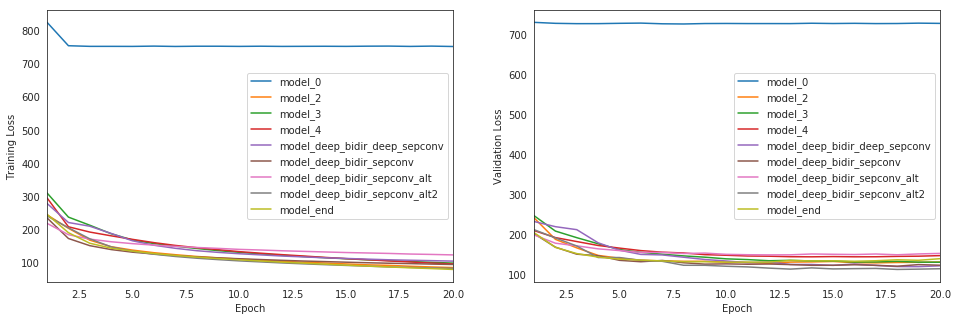

In [4]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid')

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          59648     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_____________________________________________________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
106/106 [==============================] - 251s 2s/step - loss: 245.7302 - val_loss: 203.9611
Epoch 2/20
106/106 [==============================] - 231s 2s/step - loss: 190.4269 - val_loss: 167.1593
Epoch 3/20
106/106 [==============================] - 225s 2s/step - loss: 158.7458 - val_loss: 151.6959
Epoch 4/20
106/106 [==============================] - 225s 2s/step - loss: 143.9324 - val_loss: 142.9168
Epoch 5/20
106/106 [==============================] - 231s 2s/step - loss: 134.8720 - val_loss: 137.7776
Epoch 6/20
106/106 [==============================] - 226s 2s/step - loss: 127.7138 - val_loss: 135.4012
Epoch 7/20
106/106 [==============================] - 226s 2s/step - loss: 122.0360 - val_loss: 133.3307
Epoch 8/20
106/106 [==============================] - 232s 2s/step - loss: 116.9848 - val_loss: 131.5452
Epoch 9/20
106/106 [==============

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [5]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [2]:
from wer import wer
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
import numpy as np


def calculate_wer(input_to_softmax, model_path, chars=False):
    
    
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    wers = []
    for index in range(len(data_gen.valid_texts)):
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))

        input_to_softmax.load_weights(model_path)
        prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
        output_length = [input_to_softmax.output_length(data_point.shape[0])] 
        pred_ints = (K.eval(K.ctc_decode(
                    prediction, output_length)[0][0])+1).flatten().tolist()

        pred = ''.join(int_sequence_to_text(pred_ints))

        if chars:
            w = wer(transcr.split(), pred.split())
        else:
            w = wer(list(transcr), list(pred))
        wers.append(w)
        print(index, len(data_gen.valid_texts), wers[-1])
        
    print("FINAL WER:", sum(wers) / len(wers))
        


In [3]:
calculate_wer(quartznet_12x1_15_39(161), 
                model_path='results/quartz_1212151.h5')

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, None, 128)         23151     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, 128)         0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, None, 128)         18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_____________________________________________________

33 2007 12.5
34 2007 14.285714285714285
35 2007 8.080808080808081
36 2007 33.33333333333333
37 2007 7.894736842105263
38 2007 31.746031746031743
39 2007 21.6
40 2007 23.076923076923077
41 2007 27.586206896551722
42 2007 9.615384615384617
43 2007 21.428571428571427
44 2007 11.76470588235294
45 2007 23.91304347826087
46 2007 18.367346938775512
47 2007 20.454545454545457
48 2007 13.157894736842104
49 2007 12.222222222222221
50 2007 21.951219512195124
51 2007 12.307692307692308
52 2007 23.25581395348837
53 2007 27.27272727272727
54 2007 7.6923076923076925
55 2007 2.083333333333333
56 2007 0.0
57 2007 9.30232558139535
58 2007 15.217391304347828
59 2007 11.320754716981133
60 2007 12.280701754385964
61 2007 15.0
62 2007 12.5
63 2007 16.666666666666664
64 2007 17.525773195876287
65 2007 11.811023622047244
66 2007 24.324324324324326
67 2007 41.66666666666667
68 2007 16.0
69 2007 8.823529411764707
70 2007 45.90163934426229
71 2007 6.944444444444445
72 2007 10.256410256410255
73 2007 15.384615384

355 2007 10.16949152542373
356 2007 17.02127659574468
357 2007 28.749999999999996
358 2007 16.260162601626014
359 2007 13.333333333333334
360 2007 17.5
361 2007 16.666666666666664
362 2007 19.81132075471698
363 2007 12.857142857142856
364 2007 16.0
365 2007 3.8461538461538463
366 2007 6.896551724137931
367 2007 17.105263157894736
368 2007 7.4074074074074066
369 2007 14.814814814814813
370 2007 13.88888888888889
371 2007 16.0
372 2007 8.0
373 2007 8.88888888888889
374 2007 18.91891891891892
375 2007 15.625
376 2007 12.698412698412698
377 2007 19.753086419753085
378 2007 9.67741935483871
379 2007 19.230769230769234
380 2007 20.0
381 2007 29.78723404255319
382 2007 30.0
383 2007 7.317073170731707
384 2007 21.62162162162162
385 2007 16.071428571428573
386 2007 17.24137931034483
387 2007 32.432432432432435
388 2007 3.7037037037037033
389 2007 8.21917808219178
390 2007 7.142857142857142
391 2007 10.638297872340425
392 2007 7.547169811320755
393 2007 7.874015748031496
394 2007 11.627906976744

675 2007 5.633802816901409
676 2007 14.953271028037381
677 2007 13.970588235294118
678 2007 33.33333333333333
679 2007 32.29166666666667
680 2007 18.51851851851852
681 2007 7.4074074074074066
682 2007 8.823529411764707
683 2007 2.941176470588235
684 2007 15.853658536585366
685 2007 11.11111111111111
686 2007 11.728395061728394
687 2007 5.263157894736842
688 2007 12.222222222222221
689 2007 41.66666666666667
690 2007 14.864864864864865
691 2007 16.3265306122449
692 2007 18.51851851851852
693 2007 10.256410256410255
694 2007 19.047619047619047
695 2007 11.627906976744185
696 2007 8.47457627118644
697 2007 30.0
698 2007 25.0
699 2007 27.419354838709676
700 2007 12.068965517241379
701 2007 27.659574468085108
702 2007 0.0
703 2007 9.090909090909092
704 2007 7.6923076923076925
705 2007 20.634920634920633
706 2007 21.649484536082475
707 2007 7.142857142857142
708 2007 16.176470588235293
709 2007 57.14285714285714
710 2007 13.043478260869565
711 2007 24.390243902439025
712 2007 22.033898305084

996 2007 14.634146341463413
997 2007 15.09433962264151
998 2007 21.978021978021978
999 2007 12.5
1000 2007 12.5
1001 2007 2.941176470588235
1002 2007 7.142857142857142
1003 2007 2.8169014084507045
1004 2007 25.0
1005 2007 34.21052631578947
1006 2007 4.878048780487805
1007 2007 15.254237288135593
1008 2007 19.696969696969695
1009 2007 4.395604395604396
1010 2007 7.207207207207207
1011 2007 22.535211267605636
1012 2007 16.216216216216218
1013 2007 1.2658227848101267
1014 2007 10.294117647058822
1015 2007 0.0
1016 2007 13.043478260869565
1017 2007 8.461538461538462
1018 2007 9.836065573770492
1019 2007 5.063291139240507
1020 2007 2.272727272727273
1021 2007 9.30232558139535
1022 2007 20.833333333333336
1023 2007 8.641975308641975
1024 2007 8.771929824561402
1025 2007 12.5
1026 2007 10.526315789473683
1027 2007 6.451612903225806
1028 2007 5.64516129032258
1029 2007 25.0
1030 2007 9.375
1031 2007 7.317073170731707
1032 2007 23.809523809523807
1033 2007 4.819277108433735
1034 2007 3.125
1035

1312 2007 13.559322033898304
1313 2007 14.285714285714285
1314 2007 9.090909090909092
1315 2007 21.296296296296298
1316 2007 13.750000000000002
1317 2007 21.296296296296298
1318 2007 22.916666666666664
1319 2007 15.254237288135593
1320 2007 18.0
1321 2007 29.78723404255319
1322 2007 12.222222222222221
1323 2007 24.489795918367346
1324 2007 5.405405405405405
1325 2007 9.803921568627452
1326 2007 18.181818181818183
1327 2007 22.727272727272727
1328 2007 27.77777777777778
1329 2007 2.857142857142857
1330 2007 20.0
1331 2007 4.545454545454546
1332 2007 7.4074074074074066
1333 2007 7.920792079207921
1334 2007 6.422018348623854
1335 2007 12.605042016806722
1336 2007 14.666666666666666
1337 2007 22.36842105263158
1338 2007 2.1739130434782608
1339 2007 20.0
1340 2007 6.315789473684211
1341 2007 12.658227848101266
1342 2007 13.750000000000002
1343 2007 12.195121951219512
1344 2007 12.698412698412698
1345 2007 2.857142857142857
1346 2007 17.391304347826086
1347 2007 4.545454545454546
1348 2007 7

1622 2007 18.954248366013072
1623 2007 10.071942446043165
1624 2007 51.61290322580645
1625 2007 28.57142857142857
1626 2007 20.0
1627 2007 9.090909090909092
1628 2007 7.317073170731707
1629 2007 25.581395348837212
1630 2007 11.11111111111111
1631 2007 3.3333333333333335
1632 2007 4.444444444444445
1633 2007 10.526315789473683
1634 2007 15.294117647058824
1635 2007 4.166666666666666
1636 2007 8.333333333333332
1637 2007 20.0
1638 2007 12.76595744680851
1639 2007 11.904761904761903
1640 2007 9.523809523809524
1641 2007 5.357142857142857
1642 2007 8.333333333333332
1643 2007 12.5
1644 2007 11.504424778761061
1645 2007 7.6923076923076925
1646 2007 10.526315789473683
1647 2007 11.904761904761903
1648 2007 8.108108108108109
1649 2007 7.0588235294117645
1650 2007 9.58904109589041
1651 2007 21.62162162162162
1652 2007 6.521739130434782
1653 2007 12.5
1654 2007 14.516129032258066
1655 2007 15.942028985507244
1656 2007 8.571428571428571
1657 2007 7.092198581560284
1658 2007 4.49438202247191
1659

1938 2007 2.127659574468085
1939 2007 5.454545454545454
1940 2007 19.130434782608695
1941 2007 26.53061224489796
1942 2007 5.194805194805195
1943 2007 13.953488372093023
1944 2007 7.627118644067797
1945 2007 9.322033898305085
1946 2007 8.870967741935484
1947 2007 3.4782608695652173
1948 2007 12.244897959183673
1949 2007 7.4074074074074066
1950 2007 5.813953488372093
1951 2007 13.414634146341465
1952 2007 5.384615384615385
1953 2007 7.142857142857142
1954 2007 9.574468085106384
1955 2007 13.20754716981132
1956 2007 9.195402298850574
1957 2007 16.666666666666664
1958 2007 3.076923076923077
1959 2007 6.837606837606838
1960 2007 9.090909090909092
1961 2007 11.956521739130435
1962 2007 26.08695652173913
1963 2007 33.33333333333333
1964 2007 13.725490196078432
1965 2007 57.89473684210527
1966 2007 45.83333333333333
1967 2007 12.0
1968 2007 23.404255319148938
1969 2007 0.0
1970 2007 6.363636363636363
1971 2007 12.751677852348994
1972 2007 7.4074074074074066
1973 2007 26.47058823529412
1974 20

In [4]:
calculate_wer(quartznet_12x1_15_39(161), 
                model_path='results/quartz_1212151.h5', chars=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_18 (Separab (None, None, 128)         23151     
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_17 (ReLU)              (None, None, 128)         0         
_________________________________________________________________
separable_conv1d_19 (Separab (None, None, 128)         18432     
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_18 (ReLU)              (None, None, 128)         0   

51 2007 45.45454545454545
52 2007 42.857142857142854
53 2007 66.66666666666666
54 2007 25.0
55 2007 11.11111111111111
56 2007 0.0
57 2007 34.78260869565217
58 2007 44.44444444444444
59 2007 25.0
60 2007 36.36363636363637
61 2007 50.0
62 2007 38.46153846153847
63 2007 45.0
64 2007 47.05882352941176
65 2007 43.47826086956522
66 2007 50.0
67 2007 80.0
68 2007 50.0
69 2007 28.57142857142857
70 2007 71.42857142857143
71 2007 25.0
72 2007 37.5
73 2007 31.57894736842105
74 2007 28.57142857142857
75 2007 33.33333333333333
76 2007 50.0
77 2007 17.647058823529413
78 2007 22.22222222222222
79 2007 69.23076923076923
80 2007 50.0
81 2007 53.333333333333336
82 2007 6.25
83 2007 17.647058823529413
84 2007 100.0
85 2007 50.0
86 2007 38.88888888888889
87 2007 58.333333333333336
88 2007 38.095238095238095
89 2007 31.25
90 2007 43.75
91 2007 37.5
92 2007 45.0
93 2007 8.333333333333332
94 2007 75.0
95 2007 70.37037037037037
96 2007 75.0
97 2007 61.53846153846154
98 2007 25.0
99 2007 51.724137931034484
100

418 2007 23.52941176470588
419 2007 29.411764705882355
420 2007 37.5
421 2007 47.05882352941176
422 2007 58.82352941176471
423 2007 0.0
424 2007 80.0
425 2007 33.33333333333333
426 2007 33.33333333333333
427 2007 25.0
428 2007 33.33333333333333
429 2007 50.0
430 2007 42.857142857142854
431 2007 22.22222222222222
432 2007 28.57142857142857
433 2007 42.857142857142854
434 2007 33.33333333333333
435 2007 60.0
436 2007 33.33333333333333
437 2007 21.428571428571427
438 2007 85.71428571428571
439 2007 35.294117647058826
440 2007 33.33333333333333
441 2007 40.0
442 2007 25.0
443 2007 33.33333333333333
444 2007 35.714285714285715
445 2007 11.11111111111111
446 2007 70.0
447 2007 66.66666666666666
448 2007 33.33333333333333
449 2007 33.33333333333333
450 2007 60.0
451 2007 50.0
452 2007 58.333333333333336
453 2007 45.45454545454545
454 2007 35.714285714285715
455 2007 40.0
456 2007 50.0
457 2007 33.33333333333333
458 2007 54.54545454545454
459 2007 61.111111111111114
460 2007 28.57142857142857


781 2007 46.15384615384615
782 2007 33.33333333333333
783 2007 42.857142857142854
784 2007 0.0
785 2007 25.0
786 2007 36.36363636363637
787 2007 42.857142857142854
788 2007 25.0
789 2007 43.47826086956522
790 2007 40.0
791 2007 25.0
792 2007 5.88235294117647
793 2007 33.33333333333333
794 2007 57.14285714285714
795 2007 27.27272727272727
796 2007 16.666666666666664
797 2007 23.52941176470588
798 2007 40.0
799 2007 25.0
800 2007 55.55555555555556
801 2007 63.1578947368421
802 2007 50.0
803 2007 50.0
804 2007 54.54545454545454
805 2007 23.076923076923077
806 2007 33.33333333333333
807 2007 42.857142857142854
808 2007 66.66666666666666
809 2007 50.0
810 2007 55.55555555555556
811 2007 75.0
812 2007 83.33333333333334
813 2007 50.0
814 2007 0.0
815 2007 32.0
816 2007 31.25
817 2007 34.78260869565217
818 2007 28.57142857142857
819 2007 75.0
820 2007 65.21739130434783
821 2007 0.0
822 2007 42.857142857142854
823 2007 25.0
824 2007 22.22222222222222
825 2007 76.92307692307693
826 2007 36.36363

1142 2007 0.0
1143 2007 12.5
1144 2007 4.3478260869565215
1145 2007 36.36363636363637
1146 2007 14.285714285714285
1147 2007 42.857142857142854
1148 2007 50.0
1149 2007 16.666666666666664
1150 2007 66.66666666666666
1151 2007 0.0
1152 2007 40.0
1153 2007 40.0
1154 2007 25.0
1155 2007 40.0
1156 2007 8.333333333333332
1157 2007 5.555555555555555
1158 2007 24.137931034482758
1159 2007 11.76470588235294
1160 2007 53.333333333333336
1161 2007 15.384615384615385
1162 2007 61.53846153846154
1163 2007 52.0
1164 2007 50.0
1165 2007 43.47826086956522
1166 2007 50.0
1167 2007 52.38095238095239
1168 2007 64.28571428571429
1169 2007 42.857142857142854
1170 2007 57.692307692307686
1171 2007 47.05882352941176
1172 2007 50.0
1173 2007 52.38095238095239
1174 2007 69.23076923076923
1175 2007 60.0
1176 2007 41.935483870967744
1177 2007 53.84615384615385
1178 2007 59.25925925925925
1179 2007 66.66666666666666
1180 2007 47.05882352941176
1181 2007 25.0
1182 2007 70.0
1183 2007 40.74074074074074
1184 2007 5

1490 2007 39.130434782608695
1491 2007 80.0
1492 2007 100.0
1493 2007 0.0
1494 2007 45.16129032258064
1495 2007 33.33333333333333
1496 2007 50.0
1497 2007 47.368421052631575
1498 2007 70.0
1499 2007 57.14285714285714
1500 2007 75.0
1501 2007 45.45454545454545
1502 2007 100.0
1503 2007 25.0
1504 2007 55.00000000000001
1505 2007 22.727272727272727
1506 2007 23.076923076923077
1507 2007 50.0
1508 2007 33.33333333333333
1509 2007 9.090909090909092
1510 2007 10.0
1511 2007 0.0
1512 2007 33.33333333333333
1513 2007 37.03703703703704
1514 2007 26.923076923076923
1515 2007 33.33333333333333
1516 2007 80.0
1517 2007 56.00000000000001
1518 2007 31.57894736842105
1519 2007 16.666666666666664
1520 2007 50.0
1521 2007 64.28571428571429
1522 2007 50.0
1523 2007 75.0
1524 2007 66.66666666666666
1525 2007 31.57894736842105
1526 2007 33.33333333333333
1527 2007 39.130434782608695
1528 2007 18.75
1529 2007 10.526315789473683
1530 2007 18.181818181818183
1531 2007 15.384615384615385
1532 2007 35.29411764

1834 2007 57.14285714285714
1835 2007 64.28571428571429
1836 2007 18.181818181818183
1837 2007 35.714285714285715
1838 2007 30.434782608695656
1839 2007 83.33333333333334
1840 2007 41.66666666666667
1841 2007 41.66666666666667
1842 2007 23.076923076923077
1843 2007 38.46153846153847
1844 2007 38.88888888888889
1845 2007 33.33333333333333
1846 2007 46.15384615384615
1847 2007 53.84615384615385
1848 2007 42.857142857142854
1849 2007 53.84615384615385
1850 2007 23.52941176470588
1851 2007 33.33333333333333
1852 2007 8.333333333333332
1853 2007 57.14285714285714
1854 2007 47.82608695652174
1855 2007 86.66666666666667
1856 2007 25.0
1857 2007 23.52941176470588
1858 2007 80.0
1859 2007 31.25
1860 2007 15.789473684210526
1861 2007 87.5
1862 2007 28.000000000000004
1863 2007 28.57142857142857
1864 2007 40.0
1865 2007 100.0
1866 2007 55.55555555555556
1867 2007 16.666666666666664
1868 2007 20.833333333333336
1869 2007 50.0
1870 2007 75.0
1871 2007 9.090909090909092
1872 2007 80.0
1873 2007 50.0

In [4]:
calculate_wer(input_to_softmax=quartznet_12x1(161), model_path='results/quartz_12x1.h5', chars=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, None, 256)         46785     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, 256)         0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, None, 256)         74240     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 256)         1024      
_____________________________________________________

40 2007 64.70588235294117
41 2007 88.88888888888889
42 2007 76.19047619047619
43 2007 85.71428571428571
44 2007 80.0
45 2007 85.71428571428571
46 2007 70.58823529411765
47 2007 76.47058823529412
48 2007 68.75
49 2007 82.35294117647058
50 2007 71.42857142857143
51 2007 81.81818181818183
52 2007 71.42857142857143
53 2007 100.0
54 2007 37.5
55 2007 66.66666666666666
56 2007 30.0
57 2007 65.21739130434783
58 2007 88.88888888888889
59 2007 41.66666666666667
60 2007 77.27272727272727
61 2007 75.0
62 2007 84.61538461538461
63 2007 70.0
64 2007 88.23529411764706
65 2007 73.91304347826086
66 2007 100.0
67 2007 100.0
68 2007 60.0
69 2007 71.42857142857143
70 2007 78.57142857142857
71 2007 75.0
72 2007 87.5
73 2007 63.1578947368421
74 2007 61.904761904761905
75 2007 75.0
76 2007 75.0
77 2007 70.58823529411765
78 2007 88.88888888888889
79 2007 84.61538461538461
80 2007 85.71428571428571
81 2007 80.0
82 2007 56.25
83 2007 76.47058823529412
84 2007 150.0
85 2007 80.0
86 2007 61.111111111111114
87 20

415 2007 70.37037037037037
416 2007 58.82352941176471
417 2007 57.14285714285714
418 2007 70.58823529411765
419 2007 64.70588235294117
420 2007 50.0
421 2007 82.35294117647058
422 2007 64.70588235294117
423 2007 100.0
424 2007 40.0
425 2007 44.44444444444444
426 2007 66.66666666666666
427 2007 50.0
428 2007 66.66666666666666
429 2007 50.0
430 2007 85.71428571428571
431 2007 77.77777777777779
432 2007 57.14285714285714
433 2007 71.42857142857143
434 2007 100.0
435 2007 80.0
436 2007 50.0
437 2007 28.57142857142857
438 2007 128.57142857142858
439 2007 52.94117647058824
440 2007 66.66666666666666
441 2007 40.0
442 2007 50.0
443 2007 93.33333333333333
444 2007 71.42857142857143
445 2007 88.88888888888889
446 2007 80.0
447 2007 83.33333333333334
448 2007 83.33333333333334
449 2007 83.33333333333334
450 2007 40.0
451 2007 25.0
452 2007 75.0
453 2007 72.72727272727273
454 2007 57.14285714285714
455 2007 46.666666666666664
456 2007 60.0
457 2007 75.0
458 2007 72.72727272727273
459 2007 83.3333

783 2007 71.42857142857143
784 2007 40.0
785 2007 62.5
786 2007 90.9090909090909
787 2007 66.66666666666666
788 2007 40.0
789 2007 65.21739130434783
790 2007 70.0
791 2007 50.0
792 2007 76.47058823529412
793 2007 58.333333333333336
794 2007 42.857142857142854
795 2007 54.54545454545454
796 2007 50.0
797 2007 73.52941176470588
798 2007 70.0
799 2007 150.0
800 2007 94.44444444444444
801 2007 126.3157894736842
802 2007 87.5
803 2007 107.14285714285714
804 2007 81.81818181818183
805 2007 53.84615384615385
806 2007 100.0
807 2007 71.42857142857143
808 2007 100.0
809 2007 75.0
810 2007 88.88888888888889
811 2007 75.0
812 2007 100.0
813 2007 100.0
814 2007 100.0
815 2007 84.0
816 2007 75.0
817 2007 91.30434782608695
818 2007 57.14285714285714
819 2007 100.0
820 2007 82.6086956521739
821 2007 42.857142857142854
822 2007 64.28571428571429
823 2007 100.0
824 2007 55.55555555555556
825 2007 69.23076923076923
826 2007 72.72727272727273
827 2007 53.333333333333336
828 2007 100.0
829 2007 85.7142857

1152 2007 50.0
1153 2007 80.0
1154 2007 62.5
1155 2007 80.0
1156 2007 66.66666666666666
1157 2007 50.0
1158 2007 55.172413793103445
1159 2007 64.70588235294117
1160 2007 66.66666666666666
1161 2007 46.15384615384615
1162 2007 100.0
1163 2007 72.0
1164 2007 77.77777777777779
1165 2007 78.26086956521739
1166 2007 66.66666666666666
1167 2007 76.19047619047619
1168 2007 92.85714285714286
1169 2007 78.57142857142857
1170 2007 73.07692307692307
1171 2007 70.58823529411765
1172 2007 84.61538461538461
1173 2007 85.71428571428571
1174 2007 76.92307692307693
1175 2007 80.0
1176 2007 67.74193548387096
1177 2007 88.46153846153845
1178 2007 81.48148148148148
1179 2007 85.18518518518519
1180 2007 64.70588235294117
1181 2007 62.5
1182 2007 65.0
1183 2007 62.96296296296296
1184 2007 66.66666666666666
1185 2007 66.66666666666666
1186 2007 75.0
1187 2007 84.61538461538461
1188 2007 62.5
1189 2007 83.33333333333334
1190 2007 100.0
1191 2007 0.0
1192 2007 29.411764705882355
1193 2007 150.0
1194 2007 100.0

1505 2007 59.09090909090909
1506 2007 61.53846153846154
1507 2007 100.0
1508 2007 50.0
1509 2007 81.81818181818183
1510 2007 60.0
1511 2007 60.0
1512 2007 50.0
1513 2007 66.66666666666666
1514 2007 61.53846153846154
1515 2007 50.0
1516 2007 90.0
1517 2007 76.0
1518 2007 68.42105263157895
1519 2007 100.0
1520 2007 50.0
1521 2007 82.14285714285714
1522 2007 81.25
1523 2007 75.0
1524 2007 75.0
1525 2007 89.47368421052632
1526 2007 57.14285714285714
1527 2007 65.21739130434783
1528 2007 81.25
1529 2007 63.1578947368421
1530 2007 54.54545454545454
1531 2007 46.15384615384615
1532 2007 58.82352941176471
1533 2007 57.14285714285714
1534 2007 61.53846153846154
1535 2007 65.21739130434783
1536 2007 54.83870967741935
1537 2007 50.0
1538 2007 62.5
1539 2007 78.57142857142857
1540 2007 52.94117647058824
1541 2007 41.37931034482759
1542 2007 66.66666666666666
1543 2007 51.85185185185185
1544 2007 57.14285714285714
1545 2007 75.0
1546 2007 76.92307692307693
1547 2007 70.83333333333334
1548 2007 70.8

1848 2007 85.71428571428571
1849 2007 76.92307692307693
1850 2007 76.47058823529412
1851 2007 83.33333333333334
1852 2007 50.0
1853 2007 71.42857142857143
1854 2007 78.26086956521739
1855 2007 113.33333333333333
1856 2007 91.66666666666666
1857 2007 70.58823529411765
1858 2007 100.0
1859 2007 68.75
1860 2007 63.1578947368421
1861 2007 100.0
1862 2007 80.0
1863 2007 71.42857142857143
1864 2007 90.0
1865 2007 100.0
1866 2007 66.66666666666666
1867 2007 83.33333333333334
1868 2007 58.333333333333336
1869 2007 90.0
1870 2007 87.5
1871 2007 36.36363636363637
1872 2007 70.0
1873 2007 87.5
1874 2007 100.0
1875 2007 55.55555555555556
1876 2007 90.9090909090909
1877 2007 70.0
1878 2007 55.55555555555556
1879 2007 88.88888888888889
1880 2007 77.77777777777779
1881 2007 83.33333333333334
1882 2007 76.92307692307693
1883 2007 50.0
1884 2007 78.57142857142857
1885 2007 20.0
1886 2007 57.14285714285714
1887 2007 63.63636363636363
1888 2007 80.0
1889 2007 85.71428571428571
1890 2007 66.66666666666666

In [ ]:
calculate_wer(input_to_softmax=quartznet_12x1(161), model_path='results/quartz_12x1.h5', chars=False)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [5]:
Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_18 (Separab (None, None, 256)         46785     
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 256)         1024      
_________________________________________________________________
re_lu_17 (ReLU)              (None, None, 256)         0         
_________________________________________________________________
separable_conv1d_19 (Separab (None, None, 256)         74240     
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 256)         1024      
_________________________________________________________________
re_lu_18 (ReLU)              (None, None, 256)         0   

44 2007 26.47058823529412
45 2007 34.78260869565217
46 2007 31.63265306122449
47 2007 35.22727272727273
48 2007 31.57894736842105
49 2007 32.22222222222222
50 2007 29.268292682926827
51 2007 27.692307692307693
52 2007 37.2093023255814
53 2007 40.909090909090914
54 2007 7.6923076923076925
55 2007 25.0
56 2007 9.090909090909092
57 2007 21.705426356589147
58 2007 47.82608695652174
59 2007 18.867924528301888
60 2007 28.947368421052634
61 2007 33.75
62 2007 40.625
63 2007 31.48148148148148
64 2007 37.11340206185567
65 2007 30.708661417322837
66 2007 56.75675675675676
67 2007 62.5
68 2007 32.0
69 2007 22.058823529411764
70 2007 36.0655737704918
71 2007 18.055555555555554
72 2007 30.76923076923077
73 2007 30.76923076923077
74 2007 23.300970873786408
75 2007 29.75206611570248
76 2007 45.3125
77 2007 27.906976744186046
78 2007 35.0
79 2007 37.704918032786885
80 2007 33.82352941176471
81 2007 34.285714285714285
82 2007 23.456790123456788
83 2007 22.78481012658228
84 2007 45.16129032258064
85 200

363 2007 42.857142857142854
364 2007 30.0
365 2007 15.384615384615385
366 2007 41.37931034482759
367 2007 22.36842105263158
368 2007 28.39506172839506
369 2007 35.18518518518518
370 2007 33.33333333333333
371 2007 34.0
372 2007 24.0
373 2007 32.22222222222222
374 2007 43.24324324324324
375 2007 37.5
376 2007 26.984126984126984
377 2007 39.50617283950617
378 2007 41.935483870967744
379 2007 34.61538461538461
380 2007 20.0
381 2007 44.680851063829785
382 2007 43.333333333333336
383 2007 29.268292682926827
384 2007 35.13513513513514
385 2007 37.5
386 2007 34.48275862068966
387 2007 48.64864864864865
388 2007 33.33333333333333
389 2007 19.17808219178082
390 2007 25.510204081632654
391 2007 29.78723404255319
392 2007 32.075471698113205
393 2007 35.43307086614173
394 2007 31.3953488372093
395 2007 15.053763440860216
396 2007 15.789473684210526
397 2007 22.0
398 2007 25.301204819277107
399 2007 21.69811320754717
400 2007 30.555555555555557
401 2007 33.75
402 2007 25.0
403 2007 40.0
404 2007 2

683 2007 45.588235294117645
684 2007 34.146341463414636
685 2007 20.51282051282051
686 2007 24.691358024691358
687 2007 26.31578947368421
688 2007 32.22222222222222
689 2007 41.66666666666667
690 2007 29.72972972972973
691 2007 16.3265306122449
692 2007 14.814814814814813
693 2007 35.8974358974359
694 2007 36.507936507936506
695 2007 30.23255813953488
696 2007 32.20338983050847
697 2007 37.5
698 2007 23.61111111111111
699 2007 50.0
700 2007 31.03448275862069
701 2007 55.319148936170215
702 2007 29.411764705882355
703 2007 21.21212121212121
704 2007 38.46153846153847
705 2007 49.2063492063492
706 2007 37.11340206185567
707 2007 19.642857142857142
708 2007 33.82352941176471
709 2007 71.42857142857143
710 2007 28.26086956521739
711 2007 41.46341463414634
712 2007 38.983050847457626
713 2007 52.5
714 2007 21.73913043478261
715 2007 24.242424242424242
716 2007 29.411764705882355
717 2007 20.689655172413794
718 2007 13.88888888888889
719 2007 20.0
720 2007 40.77669902912621
721 2007 17.5
722

999 2007 30.208333333333332
1000 2007 35.9375
1001 2007 25.0
1002 2007 35.714285714285715
1003 2007 39.436619718309856
1004 2007 43.05555555555556
1005 2007 31.57894736842105
1006 2007 25.609756097560975
1007 2007 33.89830508474576
1008 2007 30.303030303030305
1009 2007 18.681318681318682
1010 2007 21.62162162162162
1011 2007 28.169014084507044
1012 2007 32.432432432432435
1013 2007 20.253164556962027
1014 2007 30.88235294117647
1015 2007 0.0
1016 2007 19.565217391304348
1017 2007 18.461538461538463
1018 2007 37.704918032786885
1019 2007 15.18987341772152
1020 2007 25.0
1021 2007 31.3953488372093
1022 2007 20.833333333333336
1023 2007 12.345679012345679
1024 2007 21.929824561403507
1025 2007 38.46153846153847
1026 2007 38.59649122807017
1027 2007 22.58064516129032
1028 2007 14.516129032258066
1029 2007 28.57142857142857
1030 2007 33.59375
1031 2007 14.634146341463413
1032 2007 42.857142857142854
1033 2007 14.457831325301203
1034 2007 14.0625
1035 2007 25.0
1036 2007 29.292929292929294


1307 2007 35.8974358974359
1308 2007 57.89473684210527
1309 2007 38.095238095238095
1310 2007 31.70731707317073
1311 2007 35.59322033898305
1312 2007 38.983050847457626
1313 2007 26.53061224489796
1314 2007 29.292929292929294
1315 2007 30.555555555555557
1316 2007 48.75
1317 2007 45.370370370370374
1318 2007 43.75
1319 2007 40.67796610169492
1320 2007 30.0
1321 2007 36.17021276595745
1322 2007 41.11111111111111
1323 2007 44.89795918367347
1324 2007 24.324324324324326
1325 2007 25.49019607843137
1326 2007 50.0
1327 2007 36.36363636363637
1328 2007 43.05555555555556
1329 2007 11.428571428571429
1330 2007 33.33333333333333
1331 2007 30.303030303030305
1332 2007 18.51851851851852
1333 2007 31.683168316831683
1334 2007 19.26605504587156
1335 2007 29.411764705882355
1336 2007 36.0
1337 2007 44.73684210526316
1338 2007 28.26086956521739
1339 2007 40.0
1340 2007 31.57894736842105
1341 2007 16.455696202531644
1342 2007 31.25
1343 2007 24.390243902439025
1344 2007 17.46031746031746
1345 2007 24.

1613 2007 26.0
1614 2007 15.0
1615 2007 22.033898305084744
1616 2007 33.33333333333333
1617 2007 32.70440251572327
1618 2007 18.75
1619 2007 41.7910447761194
1620 2007 32.35294117647059
1621 2007 41.07142857142857
1622 2007 27.450980392156865
1623 2007 34.53237410071942
1624 2007 38.70967741935484
1625 2007 57.14285714285714
1626 2007 27.692307692307693
1627 2007 37.66233766233766
1628 2007 29.268292682926827
1629 2007 32.55813953488372
1630 2007 17.77777777777778
1631 2007 30.0
1632 2007 26.666666666666668
1633 2007 10.526315789473683
1634 2007 27.058823529411764
1635 2007 16.666666666666664
1636 2007 30.555555555555557
1637 2007 50.0
1638 2007 23.404255319148938
1639 2007 28.57142857142857
1640 2007 33.33333333333333
1641 2007 30.357142857142854
1642 2007 10.416666666666668
1643 2007 30.0
1644 2007 30.973451327433626
1645 2007 33.84615384615385
1646 2007 30.263157894736842
1647 2007 26.190476190476193
1648 2007 27.027027027027028
1649 2007 28.235294117647058
1650 2007 17.808219178082

1916 2007 15.686274509803921
1917 2007 23.333333333333332
1918 2007 24.242424242424242
1919 2007 38.775510204081634
1920 2007 42.10526315789473
1921 2007 43.07692307692308
1922 2007 31.0
1923 2007 24.390243902439025
1924 2007 24.050632911392405
1925 2007 35.63218390804598
1926 2007 36.11111111111111
1927 2007 28.749999999999996
1928 2007 26.229508196721312
1929 2007 32.857142857142854
1930 2007 28.000000000000004
1931 2007 33.035714285714285
1932 2007 29.268292682926827
1933 2007 36.666666666666664
1934 2007 25.49019607843137
1935 2007 31.40495867768595
1936 2007 24.675324675324674
1937 2007 26.666666666666668
1938 2007 27.659574468085108
1939 2007 25.454545454545453
1940 2007 33.04347826086956
1941 2007 28.57142857142857
1942 2007 24.675324675324674
1943 2007 30.23255813953488
1944 2007 23.728813559322035
1945 2007 19.491525423728813
1946 2007 25.0
1947 2007 18.26086956521739
1948 2007 22.448979591836736
1949 2007 28.39506172839506
1950 2007 19.767441860465116
1951 2007 32.92682926829

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [7]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid'), 
                model_path='results/model_end.h5')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          59648     
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 64)          256       
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 64)          256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          1885

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [6]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=quartznet_12x1_15_39(161), 
                model_path='results/quartz_1212151.h5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
separable_conv1d_35 (Separab (None, None, 128)         23151     
_________________________________________________________________
batch_normalization_33 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_33 (ReLU)              (None, None, 128)         0         
_________________________________________________________________
separable_conv1d_36 (Separab (None, None, 128)         18432     
_________________________________________________________________
batch_normalization_34 (Batc (None, None, 128)         512       
_________________________________________________________________
re_lu_34 (ReLU)              (None, None, 128)         0   

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!